In [1]:
import sys
sys.path.extend(["../../../../"])

In [2]:
import numpy as np
from onsager.crystal import Crystal
from onsager.crystalStars import zeroclean
from onsager.OnsagerCalc import *
from onsager.crystal import DB_disp, DB_disp4, pureDBContainer, mixedDBContainer
from onsager.DB_structs import dumbbell, SdPair, jump, connector

from scipy.constants import physical_constants
kB = physical_constants['Boltzmann constant in eV/K'][0]
from matplotlib import pyplot as plt
from collections import defaultdict

import pickle

In [3]:
%%time
# Let's load the pickle file we just saved
with open("FeX_60RT.pkl","rb") as fl:
    onsagercalculator = pickle.load(fl)

CPU times: user 7min 50s, sys: 4.8 s, total: 7min 55s
Wall time: 7min 48s


In [8]:
# Now, we'll look at the complex states in our thermodynamic shell
# For each state, the first number printed out is the index assgined to the symmetry-unique group the state
# belongs to,
# The second line tells the pure dumbbell orientation.
# The third line prints the position of the dumbbell with respect to the solute location (Recall that
# lattice parameter of BCC Fe is 0.2831 nm, as per Messina et al.'s paper)
# Note that the first complex state is an origin state (pure dumbbell on top of solute) and is unphysical.
# We'll then match our complex states, with the states shown in Messina et. al. (1nnA, 1nnB etc)
count = 0
for star in onsagercalculator.thermo.stars[:onsagercalculator.thermo.mixedstartindex]:
    print(count)
    db = star[0].db
    print(np.round(onsagercalculator.pdbcontainer.iorlist[db.iorind][1], decimals=4)+0)
    print(np.dot(onsagercalculator.crys.lattice, db.R))
    print()
    count += 1

0
[ 0.     -0.1782 -0.1782]
[0. 0. 0.]

1
[-0.1782  0.     -0.1782]
[-0.14155  0.14155 -0.14155]

2
[ 0.     -0.1782 -0.1782]
[ 0.14155  0.14155 -0.14155]

3
[ 0.     -0.1782 -0.1782]
[0.     0.     0.2831]

4
[-0.1782  0.1782  0.    ]
[ 0.      0.     -0.2831]

5
[ 0.     -0.1782 -0.1782]
[-0.2831  0.      0.2831]

6
[ 0.     -0.1782 -0.1782]
[0.     0.2831 0.2831]

7
[-0.1782  0.1782  0.    ]
[-0.2831 -0.2831  0.    ]

8
[-0.1782  0.     -0.1782]
[ 0.14155  0.14155 -0.42465]

9
[ 0.     -0.1782 -0.1782]
[0.14155 0.14155 0.42465]

10
[ 0.      0.1782 -0.1782]
[ 0.42465 -0.14155  0.14155]

11
[ 0.     -0.1782 -0.1782]
[ 0.42465  0.14155 -0.14155]

12
[ 0.      0.1782 -0.1782]
[-0.2831 -0.2831  0.2831]

13
[ 0.      0.1782 -0.1782]
[0.2831 0.2831 0.2831]

14
[-0.1782 -0.1782  0.    ]
[-0.14155 -0.42465  0.42465]

15
[-0.1782 -0.1782  0.    ]
[ 0.14155 -0.42465  0.42465]

16
[-0.1782 -0.1782  0.    ]
[-0.42465 -0.42465 -0.14155]

17
[-0.1782  0.1782  0.    ]
[-0.42465 -0.42465 -0.14155]


In [9]:
# Next, we assign labels to the states we have just identified
# No interaction will be assumed when a corresponding energy is not found in Messina et. al.'s database (such 
# as the 4nnD orientation which they did not consider)
name_to_themo_star = {"1nnA":2, "1nnB":1, "2nnA":4, "2nnB":3, "3nnA": 7, "3nnB":5, "3nnC":6,
       "4nnA":11,"4nnB":10,"4nnC":9, "4nnD":8, "5nnA":13, "5nnB":12}

In [10]:
# sorting out the jumps with the nomenclatures
jmpdict = {"1nnA_2nnA":[], "1nnA_2nnB":[], "1nnA_3nnB":[], "1nnA_3nnC":[], "1nnB_2nnB":[], "1nnB_3nnB":[],
          "1nnB_5nnB":[], "2nnA_4nnC":[], "2nnB_4nnB":[], "2nnB_4nnC":[]}
# Now identify the jumps and put them into the dictionaries
for jlistind, jlist in enumerate(onsagercalculator.jnet1):
    jmp = jlist[0]
    state1 = jmp.state1
    state2 = jmp.state2
    
    star1 = onsagercalculator.kinetic.complexIndexdict[state1][1]
    star2 = onsagercalculator.kinetic.complexIndexdict[state2][1]
    
    if star1 in onsagercalculator.thermo2kin and star2 in onsagercalculator.thermo2kin:
        thermo_star1 = onsagercalculator.thermo.complexIndexdict[state1][1]
        thermo_star2 = onsagercalculator.thermo.complexIndexdict[state2][1]
        name1 = ""
        name2 = ""
        #Now see which categories the states belong to
        star1found = False
        count1 = 0
        star2found = False
        count2 = 0
        for (key, value) in name_to_themo_star.items():
            if thermo_star1==value:
                star1found = True
                count1 += 1
                name1 = key
            if thermo_star2==value:
                star2found = True
                count2 += 1
                name2 = key
        # just to ensure we don't have any multiple counting business going on.
        if count1>1:
            print(thermo_star1)
        if count2>1:
            print(thermo_star2)
        # Now concatenate names
        jname = name1+"_"+name2
        jnamerev = name2+"_"+name1
        try:
            jmpdict[jname].append(jlistind)
        except:
            try:
                # maybe the jump we have is the reverse of what we stored as the label in the dictionary?
                jmpdict[jnamerev].append(jlistind)
            except:    
                continue

# check to see we have found all the jumps
jmpdict               

{'1nnA_2nnA': [1],
 '1nnA_2nnB': [3],
 '1nnA_3nnB': [4],
 '1nnA_3nnC': [2],
 '1nnB_2nnB': [6],
 '1nnB_3nnB': [7],
 '1nnB_5nnB': [5],
 '2nnA_4nnC': [10],
 '2nnB_4nnB': [9],
 '2nnB_4nnC': [8]}

In [11]:
E_f_pdb = 4.0799084 # formation energy of pure dumbbell - from energy file
# Now, we assign energies to the complex states in the thermo shell
# name to supercell energy
name_to_en = {"1nnA":-2081.86385487, "1nnB":-2081.96714335, 
              "2nnA":-2081.84673179, "2nnB":-2081.84805032, 
              "3nnA":-2081.86785633, "3nnB":-2081.89911432,
              "3nnC":-2081.89517078, "4nnA":-2081.89240119,
              "4nnB":-2081.88260599, "4nnC":-2081.90014080,
              "5nnA":-2081.90574167, "5nnB":-2081.89623144}

In [12]:
E_sup_pdb = -2080.58061654
E_sup_solute = -2077.70333299
E_bulk = -2076.35510458 # E_bulk is the same as E_ref
name_to_Ef = defaultdict(float)
for (key, E_IB) in name_to_en.items():
    # get the binding energy first
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    name_to_Ef[key] = E_f_pdb - Eb
name_to_Ef["4nnD"] = E_f_pdb
name_to_Ef

defaultdict(float,
            {'1nnA': 4.144898479999916,
             '1nnB': 4.041610000000197,
             '2nnA': 4.1620215600000625,
             '2nnB': 4.1607030300001275,
             '3nnA': 4.140897019999989,
             '3nnB': 4.1096390299999035,
             '3nnC': 4.113582569999813,
             '4nnA': 4.116352160000111,
             '4nnB': 4.12614736000021,
             '4nnC': 4.108612550000067,
             '5nnA': 4.103011679999759,
             '5nnB': 4.112521909999919,
             '4nnD': 4.0799084})

In [13]:
# The complex energies are set. Now, we set the mixed dumbbell energies
E_b_mdb = 2081.97387181 + E_sup_pdb + E_sup_solute - E_bulk
E_f_mdb = E_f_pdb - E_b_mdb

# Check the mixed dumbbell binding energy
print(E_f_mdb - E_f_pdb)

-0.04502686000023459


In [14]:
Jname_2_TS_en = {"1nnA_2nnA":-2081.53754083, "1nnA_2nnB":-2081.45300295, "1nnA_3nnB":-2081.54309435,
                 "1nnA_3nnC":-2081.51203629, "1nnB_2nnB":-2081.59390973, "1nnB_3nnB":-2081.58124941,
                 "1nnB_5nnB":-2081.56664001, "2nnA_4nnC":-2081.53814922, "2nnB_4nnB":-2081.53362146,
                 "2nnB_4nnC":-2081.53385038}

In [15]:
# Now, we have to find the TS energies.
Jname_2_ef_ts = defaultdict(float)
for (key, E_IB) in Jname_2_TS_en.items():
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    Jname_2_ef_ts[key] = E_f_pdb - Eb

In [16]:
Jname_2_ef_ts

defaultdict(float,
            {'1nnA_2nnA': 4.471212519999859,
             '1nnA_2nnB': 4.5557503999998294,
             '1nnA_3nnB': 4.465658999999937,
             '1nnA_3nnC': 4.496717059999788,
             '1nnB_2nnB': 4.4148436199998065,
             '1nnB_3nnB': 4.427503939999929,
             '1nnB_5nnB': 4.442113340000083,
             '2nnA_4nnC': 4.470604130000061,
             '2nnB_4nnB': 4.475131889999807,
             '2nnB_4nnC': 4.474902970000108})

In [17]:
Jname_2_mig = defaultdict(float)
for (key, TS_en) in Jname_2_ef_ts.items():
    initstar = key[:4]
    Jname_2_mig[key] = TS_en - name_to_Ef[initstar]

In [18]:
# Check that correct energies have been assigned to the jumps
Jname_2_mig

defaultdict(float,
            {'1nnA_2nnA': 0.3263140399999429,
             '1nnA_2nnB': 0.41085191999991366,
             '1nnA_3nnB': 0.32076052000002164,
             '1nnA_3nnC': 0.35181857999987187,
             '1nnB_2nnB': 0.3732336199996098,
             '1nnB_3nnB': 0.38589393999973254,
             '1nnB_5nnB': 0.4005033399998865,
             '2nnA_4nnC': 0.30858256999999867,
             '2nnB_4nnB': 0.31442885999967984,
             '2nnB_4nnC': 0.3141999399999804})

In [19]:
E_IB_43, E_IB_2 = -2081.60898764, -2081.73238117
Eb_43, Eb_2 = -E_IB_43 + E_sup_pdb + E_sup_solute - E_bulk, -E_IB_2 + E_sup_pdb + E_sup_solute - E_bulk 
# Next, get the formation energy (relative to solute formation energy)
ef_ts_43 = E_f_pdb - Eb_43
ef_ts_2 = E_f_pdb - Eb_2
print(ef_ts_2-E_f_mdb, ef_ts_43 - E_f_mdb, ef_ts_43 - name_to_Ef["1nnB"])

0.2414906400003929 0.36488417000009576 0.3581557099996644


In [20]:
# get the SCMF PDC data from the file to compare to
temp = []
pdcr = []
with open("PDC_ratio_Cr.dat", "r") as fl:
    for line in fl:
        arr = line.split()
        temp.append(float(arr[0]))
        pdcr.append(float(arr[1]))
temp = np.array(temp)
pdcr = np.array(pdcr)

drag = []
with open("DragRatio_Cr.dat","r") as fl:
    for line in fl:
        arr = line.split()
        drag.append(float(arr[0]))
drag = np.array(drag)

## Cr calculations

In [21]:
# Jump rates and energy barriers set. Now, let's set the calculations up.
vu0=4.4447
vu2=4.5551
Dconv=1.

predb0, enedb0 = np.ones(1), np.array([E_f_pdb])

# We'll measure every formation energy relative to the solute formation energy.
preS, eneS = np.ones(1), np.array([0.0])

# Next, interaction or the excess energies and pre-factors for solutes and dumbbells.
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.zeros(onsagercalculator.thermo.mixedstartindex)
# Now, we go over the necessary stars and assign interaction energies
for (key, index) in name_to_themo_star.items():
    eneSdb[index] = name_to_Ef[key] - E_f_pdb

predb2, enedb2 = np.ones(1), np.array([E_f_mdb])

# Transition state energies - For omega0, omega2 and omega43, the first type is the Johnson jump,
# and the second one is the Rigid jump.

# Omega0 TS eneriges
preT0, eneT0 = Dconv*vu0*np.ones(1), np.array([E_f_pdb + 0.33759025])

# Omega2 TS energies
Nj2 = len(onsagercalculator.jnet2)
preT2, eneT2 = Dconv*vu2*np.ones(Nj2), np.array([ef_ts_2])

# Omega43 TS energies
preT43, eneT43 = Dconv*vu0*np.ones(1), np.array([ef_ts_43])

# Omega1 TS energies - need to be careful here
preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))
eneT1 = np.array([eneT0[i] for i in onsagercalculator.om1types])
# Now, we go over the jumps that are provided and make the necessary changes
for (key, index) in jmpdict.items():
    eneT1[index] = Jname_2_ef_ts[key]
    
# set origin state jumps to zeros - the code handles this anyway
eneT1[0] = 0.0

In [22]:
# Then we calculate the transport coefficients
from tqdm import tqdm

diff_aa_Cr = np.zeros(len(temp))
diff_ab_Cr = np.zeros(len(temp))
diff_bb = np.zeros(len(temp))
diff_bb_non_loc = np.zeros(len(temp))

start = time.time()
for i in tqdm(range(len(temp)), position=0, leave=True):
    T = temp[i]
    kT = kB*T
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)

    # get the probabilities and other data from L_ij
    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Cr[i] = L_aa[0][0]
    diff_ab_Cr[i] = L_ab[0][0]
    diff_bb[i] = L_bb[0][0]
    diff_bb_non_loc[i] = L0bb[0][0]
        
print(time.time() - start)

100%|██████████| 381/381 [25:13<00:00,  3.97s/it]

1513.5864696502686


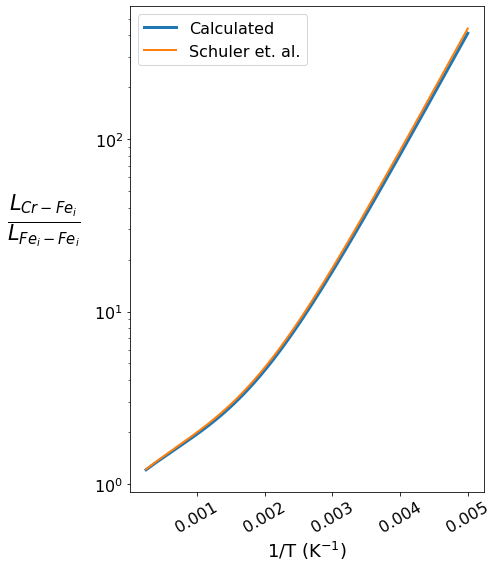

In [23]:
# Next, compare the pdc ratio
T_arr = temp
plt.figure(figsize=(7,8))
plt.semilogy(1/T_arr, diff_ab_Cr/(diff_bb_non_loc), label="Calculated", linewidth=3)
plt.semilogy(1/temp, np.array(pdcr), linewidth=2,
             label="Schuler et. al.")
plt.xlabel(r"1/T (K$^{-1}$)", fontsize=18)
plt.ylabel(r"$\frac{L_{Cr-Fe_i}}{L_{Fe_i-Fe_i}}$", fontsize=30, rotation = 0, labelpad=50)

plt.xticks(fontsize=16, rotation = 30)
plt.yticks(fontsize=16)
# plt.xlim(400, 1301)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig("pdc_ratio_Cr_Fe_log.png")

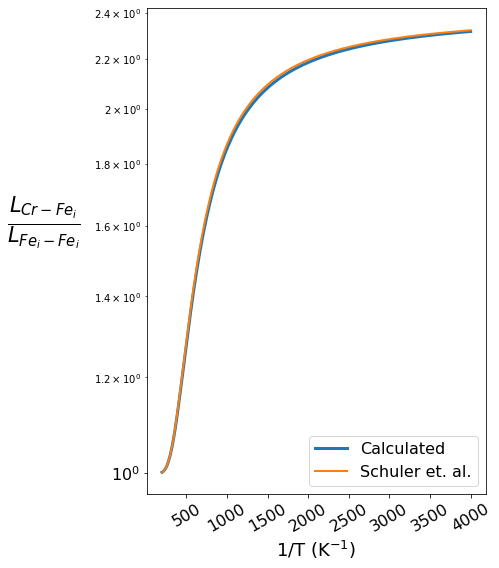

In [24]:
# Next, compare the drag ratio
T_arr = temp
plt.figure(figsize=(7,8))
plt.plot(T_arr, diff_ab_Cr/(diff_aa_Cr), label="Calculated", linewidth=3)
plt.plot(temp, np.array(drag), linewidth=2,
             label="Schuler et. al.")
plt.xlabel(r"1/T (K$^{-1}$)", fontsize=18)
plt.ylabel(r"$\frac{L_{Cr-Fe_i}}{L_{Fe_i-Fe_i}}$", fontsize=30, rotation = 0, labelpad=50)
# plt.legend(loc="best", fontsize=16)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=16, rotation = 30)
plt.yticks(fontsize=16)
# plt.xlim(400, 1301)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig("pdc_ratio_Cr_Fe_log.png")

In [25]:
# Now save the data
import h5py
with h5py.File("Cr_data.h5","w") as fl:
    fl.create_dataset("diff_aa", data=diff_aa_Cr)
    fl.create_dataset("diff_ab", data=diff_ab_Cr)
    fl.create_dataset("diff_bb_nl", data=diff_bb_non_loc)
    fl.create_dataset("diff_bb", data=diff_bb)
    fl.create_dataset("Temp", data=np.array(temp))

In [26]:
# Now let's do the infinite temeperature limit
kT = np.inf
bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
    onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                           preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
#     bFdicts[i] = [bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4]
# get the probabilities and other data from L_ij
L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

L_aa = L_uc_aa + L_c_aa
L_bb = L_uc_bb + L_c_bb
L_ab = L_uc_ab + L_c_ab

In [28]:
# Get the drag ratio
L_ab[0][0]/L_aa[0][0]

2.4171370058101593